# FastAI with PyTorch
We will now look at training our own models on Sinopia's RDF for a couple of classification tasks. [FastAI][FASTAI] is a non-profit that provides artificial intellegence training and for our use today, an easy-to-use Python software library that is built upon the [PyTorch](https://pytorch.org/) open-source machine learning framework from Facebook that is widely used in industry and academic research.

[FASTAI]: https://www.fast.ai/

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext lab_black

from fastai.tabular.all import *

import pandas as pd

import kglab
import rdflib
import helpers
import widgets

## Loading Sinopia Stage RDF Text DataFrame

In [2]:
stage_kg = kglab.KnowledgeGraph()
stage_kg.load_jsonld("data/stage.json")

## Classifing RDF resource by their Template
In Sinopia, each resource uses at least one resource template for constructing the Sinopia's user interface. Currently, when a user imports RDF into the editor, either through the Questioning Authority search or through the **Load RDF** tab, the user is prompted to selected the template to use and Sinopia does its best to matche the template's properties to the incoming RDF.

This classification task extends the initial work done in 2020 year's LD4 presentation, 
[A Machine Learning Approach for Classifying Sinopia's RDF](https://ld4p.github.io/classify-rdf-2020/).

### Step One - Generate Pandas Dataframe
We will run a SPARQL query on our stage knowledge graph, iterate through the results to generate a list of dictionaries from the `helpers.predicate_row`. 

In [3]:
data = []
for row in stage_kg.query(
    """
SELECT ?template ?url 
WHERE {
   ?url <http://sinopia.io/vocabulary/hasResourceTemplate> ?template .
   FILTER isIRI(?url)
} """
):
    # Skip if RDF resource is a Sinopia resource template
    if str(row[0]).startswith("sinopia:template:resource"):
        continue
    data.append(helpers.predicate_row(row[1], stage_kg.rdf_graph()))

In [4]:
data[0:10]

[{'uri': 'https://api.stage.sinopia.io/resource/25bf2f7d-5739-4098-b754-46234f7d5a85',
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': 1.0,
  'http://id.loc.gov/ontologies/bibframe/adminMetadata': 1.0,
  'http://id.loc.gov/ontologies/bibframe/originDate': 1.0,
  'http://id.loc.gov/ontologies/bibframe/subject': 2.0,
  'http://id.loc.gov/ontologies/bibframe/title': 2.0,
  'http://id.loc.gov/ontologies/bflc/creatorCharacteristic': 1.0,
  'http://www.w3.org/2002/07/owl#sameAs': 1.0,
  'template': 'WAU:RT:BF2:Work',
  'http://sinopia.io/vocabulary/hasResourceTemplate': 1.0,
  'http://www.w3.org/2004/02/skos/core#prefLabel': 1.0},
 {'uri': 'https://api.stage.sinopia.io/resource/cdc2bdca-762d-40b1-ad97-adb0bcf018f2',
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': 1.0,
  'http://id.loc.gov/ontologies/bibframe/adminMetadata': 1.0,
  'http://id.loc.gov/ontologies/bibframe/genreForm': 1.0,
  'http://id.loc.gov/ontologies/bibframe/relatedTo': 1.0,
  'http://id.loc.gov/ontologies/bibfram

For the list of dictionaries that have the predicate frequencies, create a Pandas DataFrame and then replace missing values with zeros.

In [5]:
stage_df = pd.DataFrame(data)
stage_df = stage_df.fillna(0.0)

Shape and information about the `stage_df` DataFrame

In [6]:
print(stage_df.shape)
print(stage_df.info())

(2342, 264)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Columns: 264 entries, uri to http://www.w3.org/1999/02/22-rdf-syntax-ns#value
dtypes: float64(262), object(2)
memory usage: 4.7+ MB
None


Generate a random sample of 10 to see examples of individual Series in the DataFrame

In [7]:
stage_df.sample(10)

,uri,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.loc.gov/ontologies/bibframe/adminMetadata,http://id.loc.gov/ontologies/bibframe/originDate,http://id.loc.gov/ontologies/bibframe/subject,http://id.loc.gov/ontologies/bibframe/title,http://id.loc.gov/ontologies/bflc/creatorCharacteristic,http://www.w3.org/2002/07/owl#sameAs,template,http://sinopia.io/vocabulary/hasResourceTemplate,...,http://rdaregistry.info/Elements/w/P10221,http://www.loc.gov/mads/rdf/v1#birthDate,http://id.loc.gov/ontologies/bibframe/Contribution,http://id.loc.gov/ontologies/bibframe/VariantTitle,https://data.ub.uio.no/skosmos/humord/nb/,https://vokabular.bs.no/webdewey/nb/,http://id.loc.gov/ontologies/bibframe/agent,http://id.loc.gov/ontologies/bibframe/role,http://id.loc.gov/ontologies/bflc/appliesTo,http://www.w3.org/1999/02/22-rdf-syntax-ns#value
793,https://api.stage.sinopia.io/resource/49d2d46d-d4f8-4fee-b70b-8ac118234b6d,1.0,1.0,0.0,0.0,3.0,0.0,0.0,hrc:RT:bf2:RareMat:Instance,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1684,https://api.stage.sinopia.io/resource/84e65053-3b4a-46df-a082-235e0ee65399,1.0,1.0,0.0,0.0,1.0,0.0,0.0,ld4p:RT:bf2:Serial:Instance:Un-nested,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,https://api.stage.sinopia.io/resource/323a3f82-1095-4d0b-96a6-08bc2a511789,2.0,0.0,1.0,5.0,1.0,0.0,0.0,pcc:bf2:Monograph:Work,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1735,https://api.stage.sinopia.io/resource/781b71cd-d072-4b57-8c30-8fe1c3898a71,1.0,1.0,0.0,0.0,1.0,0.0,1.0,WAU:RT:BF2:Instance,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2176,https://api.stage.sinopia.io/resource/0b281fbd-6fbc-423d-ada3-3a3314088969,1.0,1.0,0.0,0.0,0.0,0.0,0.0,norld:RT:RDA:Monografi:Verk,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,https://api.stage.sinopia.io/resource/7b0175c3-02bb-49e9-aa70-f90762c00615,1.0,1.0,1.0,0.0,0.0,0.0,1.0,WAU:RT:BF2:Work,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,https://api.stage.sinopia.io/resource/3fed7bf9-8697-44c1-aa94-a36a3eae59db,1.0,1.0,0.0,0.0,0.0,0.0,1.0,WAU:RT:BF2:Work,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,https://api.stage.sinopia.io/resource/c410f621-1723-4698-96fc-6e0a451f2abd,1.0,1.0,1.0,0.0,1.0,0.0,1.0,WAU:RT:BF2:Work,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1445,https://api.stage.sinopia.io/resource/02662a71-77d7-45b7-aed5-b38bc3e82f84,1.0,0.0,0.0,0.0,0.0,0.0,0.0,pcc:bf2:Monograph:Item,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1646,https://api.stage.sinopia.io/resource/48e22d5e-8ef3-4832-b604-d5be9902e470,1.0,1.0,0.0,0.0,0.0,0.0,0.0,norld:RT:RDA:Monografi:Uttrykk,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step Two - Split, Preprocess, and Load Data
First we will create a copy of `stage_df` DataFrame, removing the `uri` column as we don't want to train our model on this identifier. Later if we need, we can lookup the `uri` in the original `stage_df` dataframe to retrieve the URI. We will also remove the `sinopia:hasResourceTemplate` column because it doesn't add any information. We will then make sure that we don't have rows that have unique templates (as this will impact later training).

In [8]:
stage_df_copy = stage_df.drop(
    columns=["uri", "http://sinopia.io/vocabulary/hasResourceTemplate"]
)
stage_df_clean = stage_df_copy[
    stage_df_copy.duplicated(subset=["template"], keep=False)
]

In [9]:
stage_df_clean.head()

,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.loc.gov/ontologies/bibframe/adminMetadata,http://id.loc.gov/ontologies/bibframe/originDate,http://id.loc.gov/ontologies/bibframe/subject,http://id.loc.gov/ontologies/bibframe/title,http://id.loc.gov/ontologies/bflc/creatorCharacteristic,http://www.w3.org/2002/07/owl#sameAs,template,http://www.w3.org/2004/02/skos/core#prefLabel,http://id.loc.gov/ontologies/bibframe/genreForm,...,http://rdaregistry.info/Elements/w/P10221,http://www.loc.gov/mads/rdf/v1#birthDate,http://id.loc.gov/ontologies/bibframe/Contribution,http://id.loc.gov/ontologies/bibframe/VariantTitle,https://data.ub.uio.no/skosmos/humord/nb/,https://vokabular.bs.no/webdewey/nb/,http://id.loc.gov/ontologies/bibframe/agent,http://id.loc.gov/ontologies/bibframe/role,http://id.loc.gov/ontologies/bflc/appliesTo,http://www.w3.org/1999/02/22-rdf-syntax-ns#value
0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,WAU:RT:BF2:Work,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,2.0,2.0,0.0,1.0,WAU:RT:BF2:Work,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,WAU:RT:BF2:Work,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,1.0,WAU:RT:BF2:Work,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0,1.0,WAU:RT:BF2:Work,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we split our data into training and validation sets with our validation set contain 20% of data.

In [10]:
splits = helpers.create_splits(stage_df_clean)

Using the FastAI's TabularPandas class, we will pass in some parameters to preprocess the `stage_df_copy`.

In [11]:
stage_df_clean.head()

,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.loc.gov/ontologies/bibframe/adminMetadata,http://id.loc.gov/ontologies/bibframe/originDate,http://id.loc.gov/ontologies/bibframe/subject,http://id.loc.gov/ontologies/bibframe/title,http://id.loc.gov/ontologies/bflc/creatorCharacteristic,http://www.w3.org/2002/07/owl#sameAs,template,http://www.w3.org/2004/02/skos/core#prefLabel,http://id.loc.gov/ontologies/bibframe/genreForm,...,http://rdaregistry.info/Elements/w/P10221,http://www.loc.gov/mads/rdf/v1#birthDate,http://id.loc.gov/ontologies/bibframe/Contribution,http://id.loc.gov/ontologies/bibframe/VariantTitle,https://data.ub.uio.no/skosmos/humord/nb/,https://vokabular.bs.no/webdewey/nb/,http://id.loc.gov/ontologies/bibframe/agent,http://id.loc.gov/ontologies/bibframe/role,http://id.loc.gov/ontologies/bflc/appliesTo,http://www.w3.org/1999/02/22-rdf-syntax-ns#value
0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,WAU:RT:BF2:Work,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,2.0,2.0,0.0,1.0,WAU:RT:BF2:Work,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,WAU:RT:BF2:Work,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,1.0,WAU:RT:BF2:Work,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0,1.0,WAU:RT:BF2:Work,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
stage_df_clean["template"]

0                      WAU:RT:BF2:Work
1                      WAU:RT:BF2:Work
2                      WAU:RT:BF2:Work
3                      WAU:RT:BF2:Work
4                      WAU:RT:BF2:Work
                     ...              
2325      hrc:RT:bf2:Work:version_test
2326        ld4p:RT:bf2:Monograph:Work
2327        ld4p:RT:bf2:Monograph:Work
2330    stanford:bf2:TestTemplate:Work
2331    stanford:bf2:TestTemplate:Work
Name: template, Length: 2304, dtype: object

In [14]:
continuous = [col for col in stage_df_clean.columns if col != "template"]

In [12]:
TabularPandas?

Init signature:
TabularPandas(
    df,
    procs=None,
    cat_names=None,
    cont_names=None,
    y_names=None,
    y_block=None,
    splits=None,
    do_setup=True,
    device=None,
    inplace=False,
    reduce_memory=True,
)
Docstring:      A `Tabular` object with transforms
File:           ~/70-79 Presentations/70.02 RDF-AI Workshop - 02022 LD4 Conference/ld4-env/lib/python3.10/site-packages/fastai/tabular/core.py
Type:           type
Subclasses:     


In [15]:
stage_to = TabularPandas(
    stage_df_clean,
    procs=[Categorify],
    cont_names=continuous,
    y_names="template",
    y_block=CategoryBlock,
    splits=splits,
)

In [16]:
stage_to.xs.iloc[:2]

,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.loc.gov/ontologies/bibframe/adminMetadata,http://id.loc.gov/ontologies/bibframe/originDate,http://id.loc.gov/ontologies/bibframe/subject,http://id.loc.gov/ontologies/bibframe/title,http://id.loc.gov/ontologies/bflc/creatorCharacteristic,http://www.w3.org/2002/07/owl#sameAs,http://www.w3.org/2004/02/skos/core#prefLabel,http://id.loc.gov/ontologies/bibframe/genreForm,http://id.loc.gov/ontologies/bibframe/relatedTo,...,http://rdaregistry.info/Elements/w/P10221,http://www.loc.gov/mads/rdf/v1#birthDate,http://id.loc.gov/ontologies/bibframe/Contribution,http://id.loc.gov/ontologies/bibframe/VariantTitle,https://data.ub.uio.no/skosmos/humord/nb/,https://vokabular.bs.no/webdewey/nb/,http://id.loc.gov/ontologies/bibframe/agent,http://id.loc.gov/ontologies/bibframe/role,http://id.loc.gov/ontologies/bflc/appliesTo,http://www.w3.org/1999/02/22-rdf-syntax-ns#value
1088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1086,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we will create a FastAI `DataLoader` that we can pass to the `learner` object for training our model.

In [17]:
stage_data_loader = stage_to.dataloaders(bs=64, device="cpu")

The `TabularDataLoader` provides a method batching up our data in groups of 64 (set when we passed in the `bs` parameter above) and we see an example of a batch.

In [18]:
stage_data_loader.show_batch()

,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.loc.gov/ontologies/bibframe/adminMetadata,http://id.loc.gov/ontologies/bibframe/originDate,http://id.loc.gov/ontologies/bibframe/subject,http://id.loc.gov/ontologies/bibframe/title,http://id.loc.gov/ontologies/bflc/creatorCharacteristic,http://www.w3.org/2002/07/owl#sameAs,http://www.w3.org/2004/02/skos/core#prefLabel,http://id.loc.gov/ontologies/bibframe/genreForm,http://id.loc.gov/ontologies/bibframe/relatedTo,http://www.w3.org/2004/02/skos/core#altLabel,http://id.loc.gov/ontologies/bibframe/content,http://id.loc.gov/ontologies/bibframe/expressionOf,http://id.loc.gov/ontologies/bibframe/identifiedBy,http://id.loc.gov/ontologies/bibframe/language,http://id.loc.gov/ontologies/bibframe/notation,http://id.loc.gov/ontologies/bibframe/summary,http://id.loc.gov/ontologies/bibframe/supplementaryContent,http://id.loc.gov/ontologies/bibframe/note,http://id.loc.gov/ontologies/bibframe/dissertation,http://id.loc.gov/ontologies/bibframe/originPlace,http://id.loc.gov/ontologies/bibframe/intendedAudience,http://id.loc.gov/ontologies/bibframe/colorContent,http://id.loc.gov/ontologies/bibframe/illustrativeContent,http://id.loc.gov/ontologies/bibframe/contribution,http://id.loc.gov/ontologies/bibframe/precededBy,http://id.loc.gov/ontologies/bibframe/succeededBy,http://id.loc.gov/ontologies/bibframe/partOf,http://id.loc.gov/ontologies/bibframe/translationOf,http://id.loc.gov/ontologies/bibframe/hasDerivative,http://id.loc.gov/ontologies/bibframe/replacementOf,http://id.loc.gov/ontologies/bibframe/historyOfWork,http://id.loc.gov/ontologies/bibframe/cartographicAttributes,http://id.loc.gov/ontologies/bibframe/derivativeOf,http://id.loc.gov/ontologies/bibframe/hasExpression,http://id.loc.gov/ontologies/bibframe/duration,http://id.loc.gov/ontologies/bibframe/scale,http://id.loc.gov/ontologies/bibframe/awards,http://id.loc.gov/ontologies/bibframe/hasPart,http://id.loc.gov/ontologies/bibframe/geographicCoverage,http://id.loc.gov/ontologies/bibframe/natureOfContent,http://id.loc.gov/ontologies/bibframe/hasInstance,http://id.loc.gov/ontologies/bibframe/index,http://id.loc.gov/ontologies/bibframe/aspectRatio,http://id.loc.gov/ontologies/bibframe/carrier,http://id.loc.gov/ontologies/bibframe/credits,http://id.loc.gov/ontologies/bibframe/digitalCharacteristic,http://id.loc.gov/ontologies/bibframe/dimensions,http://id.loc.gov/ontologies/bibframe/extent,http://id.loc.gov/ontologies/bibframe/instanceOf,http://id.loc.gov/ontologies/bibframe/issuance,http://id.loc.gov/ontologies/bibframe/media,http://id.loc.gov/ontologies/bibframe/productionMethod,http://id.loc.gov/ontologies/bibframe/provisionActivity,http://id.loc.gov/ontologies/bibframe/provisionActivityStatement,http://id.loc.gov/ontologies/bibframe/responsibilityStatement,http://id.loc.gov/ontologies/bibframe/soundCharacteristic,http://id.loc.gov/ontologies/bibframe/videoCharacteristic,http://www.w3.org/2000/01/rdf-schema#label,http://id.loc.gov/ontologies/bibframe/copyrightDate,http://id.loc.gov/ontologies/bflc/relationship,http://id.loc.gov/ontologies/bibframe/contentAccessibility,http://id.loc.gov/ontologies/bibframe/hasItem,http://id.loc.gov/ontologies/bibframe/editionStatement,http://id.loc.gov/ontologies/bibframe/seriesStatement,http://id.loc.gov/ontologies/bibframe/systemRequirement,http://id.loc.gov/ontologies/bibframe/electronicLocator,http://www.w3.org/1999/02/22-rdf-syntax-ns#/type,http://id.loc.gov/ontologies/bibframe/hasSeries,http://id.loc.gov/ontologies/bibframe/classification,http://id.loc.gov/ontologies/bibframe/tableOfContents,http://id.loc.gov/ontologies/bibframe/temporalCoverage,http://id.loc.gov/ontologies/bibframe/identifier,http://sinopia.io/vocabulary/exportDate,http://sinopia.io/vocabulary/localAdminMetadataFor,http://id.loc.gov/ontologies/bflc/catalogerId,http://id.loc.gov/ontologies/bibframe/bookFormat,https://w3id.org/arm/core/ontology/0.1/hasCitation,https://w3id.org/arm/core/ontology/0.1/hasSignatureStatement,https:/

### Step Three - Create Learner and Train Model

In [19]:
stage_learner = tabular_learner(stage_data_loader, metrics=accuracy)

In [20]:
stage_learner.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(261, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=261, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=67, bias=True)
    )
  )
)

In our `TabularModel` neural net we have three layers, with the first input layer does the following:
  1.  Applies a PyTorch [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to the incoming data
  1.  Applies the PyTorch [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) activation
  1.  Applies a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) on our batch of 65
  
The second hidden layer of does similar processing as our first layer and the layer third produces the final results.

With the `stage_learner` object, we can graphically estimate the learning rate that will be used in training our new model. We can examine the model by printing it out:

SuggestedLRs(valley=0.0014454397605732083)

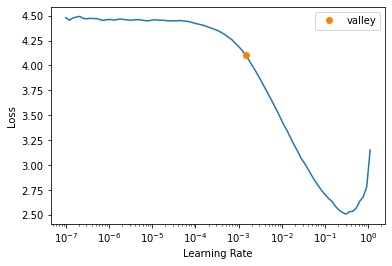

In [21]:
stage_learner.lr_find()

In [22]:
stage_learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,3.566067,3.013358,0.626033,00:00
1,2.185263,1.094496,0.776860,00:00
2,1.443666,0.970445,0.750000,00:00
3,1.045982,1.276099,0.758264,00:00
4,0.824214,1.470159,0.750000,00:00


In [23]:
stage_learner.show_results()

,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.loc.gov/ontologies/bibframe/adminMetadata,http://id.loc.gov/ontologies/bibframe/originDate,http://id.loc.gov/ontologies/bibframe/subject,http://id.loc.gov/ontologies/bibframe/title,http://id.loc.gov/ontologies/bflc/creatorCharacteristic,http://www.w3.org/2002/07/owl#sameAs,http://www.w3.org/2004/02/skos/core#prefLabel,http://id.loc.gov/ontologies/bibframe/genreForm,http://id.loc.gov/ontologies/bibframe/relatedTo,http://www.w3.org/2004/02/skos/core#altLabel,http://id.loc.gov/ontologies/bibframe/content,http://id.loc.gov/ontologies/bibframe/expressionOf,http://id.loc.gov/ontologies/bibframe/identifiedBy,http://id.loc.gov/ontologies/bibframe/language,http://id.loc.gov/ontologies/bibframe/notation,http://id.loc.gov/ontologies/bibframe/summary,http://id.loc.gov/ontologies/bibframe/supplementaryContent,http://id.loc.gov/ontologies/bibframe/note,http://id.loc.gov/ontologies/bibframe/dissertation,http://id.loc.gov/ontologies/bibframe/originPlace,http://id.loc.gov/ontologies/bibframe/intendedAudience,http://id.loc.gov/ontologies/bibframe/colorContent,http://id.loc.gov/ontologies/bibframe/illustrativeContent,http://id.loc.gov/ontologies/bibframe/contribution,http://id.loc.gov/ontologies/bibframe/precededBy,http://id.loc.gov/ontologies/bibframe/succeededBy,http://id.loc.gov/ontologies/bibframe/partOf,http://id.loc.gov/ontologies/bibframe/translationOf,http://id.loc.gov/ontologies/bibframe/hasDerivative,http://id.loc.gov/ontologies/bibframe/replacementOf,http://id.loc.gov/ontologies/bibframe/historyOfWork,http://id.loc.gov/ontologies/bibframe/cartographicAttributes,http://id.loc.gov/ontologies/bibframe/derivativeOf,http://id.loc.gov/ontologies/bibframe/hasExpression,http://id.loc.gov/ontologies/bibframe/duration,http://id.loc.gov/ontologies/bibframe/scale,http://id.loc.gov/ontologies/bibframe/awards,http://id.loc.gov/ontologies/bibframe/hasPart,http://id.loc.gov/ontologies/bibframe/geographicCoverage,http://id.loc.gov/ontologies/bibframe/natureOfContent,http://id.loc.gov/ontologies/bibframe/hasInstance,http://id.loc.gov/ontologies/bibframe/index,http://id.loc.gov/ontologies/bibframe/aspectRatio,http://id.loc.gov/ontologies/bibframe/carrier,http://id.loc.gov/ontologies/bibframe/credits,http://id.loc.gov/ontologies/bibframe/digitalCharacteristic,http://id.loc.gov/ontologies/bibframe/dimensions,http://id.loc.gov/ontologies/bibframe/extent,http://id.loc.gov/ontologies/bibframe/instanceOf,http://id.loc.gov/ontologies/bibframe/issuance,http://id.loc.gov/ontologies/bibframe/media,http://id.loc.gov/ontologies/bibframe/productionMethod,http://id.loc.gov/ontologies/bibframe/provisionActivity,http://id.loc.gov/ontologies/bibframe/provisionActivityStatement,http://id.loc.gov/ontologies/bibframe/responsibilityStatement,http://id.loc.gov/ontologies/bibframe/soundCharacteristic,http://id.loc.gov/ontologies/bibframe/videoCharacteristic,http://www.w3.org/2000/01/rdf-schema#label,http://id.loc.gov/ontologies/bibframe/copyrightDate,http://id.loc.gov/ontologies/bflc/relationship,http://id.loc.gov/ontologies/bibframe/contentAccessibility,http://id.loc.gov/ontologies/bibframe/hasItem,http://id.loc.gov/ontologies/bibframe/editionStatement,http://id.loc.gov/ontologies/bibframe/seriesStatement,http://id.loc.gov/ontologies/bibframe/systemRequirement,http://id.loc.gov/ontologies/bibframe/electronicLocator,http://www.w3.org/1999/02/22-rdf-syntax-ns#/type,http://id.loc.gov/ontologies/bibframe/hasSeries,http://id.loc.gov/ontologies/bibframe/classification,http://id.loc.gov/ontologies/bibframe/tableOfContents,http://id.loc.gov/ontologies/bibframe/temporalCoverage,http://id.loc.gov/ontologies/bibframe/identifier,http://sinopia.io/vocabulary/exportDate,http://sinopia.io/vocabulary/localAdminMetadataFor,http://id.loc.gov/ontologies/bflc/catalogerId,http://id.loc.gov/ontologies/bibframe/bookFormat,https://w3id.org/arm/core/ontology/0.1/hasCitation,https://w3id.org/arm/core/ontology/0.1/hasSignatureStatement,https:/

In [35]:
test_stage_df = stage_df.copy()
# test_stage_df.drop(["template"], axis=1, inplace=True)

In [36]:
test_stage_df.iloc[45].template

'WAU:RT:BF2:Work'

In [27]:
row, class_, probs = stage_learner.predict(test_stage_df.iloc[45])

In [29]:
row.show()

,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.loc.gov/ontologies/bibframe/adminMetadata,http://id.loc.gov/ontologies/bibframe/originDate,http://id.loc.gov/ontologies/bibframe/subject,http://id.loc.gov/ontologies/bibframe/title,http://id.loc.gov/ontologies/bflc/creatorCharacteristic,http://www.w3.org/2002/07/owl#sameAs,http://www.w3.org/2004/02/skos/core#prefLabel,http://id.loc.gov/ontologies/bibframe/genreForm,http://id.loc.gov/ontologies/bibframe/relatedTo,http://www.w3.org/2004/02/skos/core#altLabel,http://id.loc.gov/ontologies/bibframe/content,http://id.loc.gov/ontologies/bibframe/expressionOf,http://id.loc.gov/ontologies/bibframe/identifiedBy,http://id.loc.gov/ontologies/bibframe/language,http://id.loc.gov/ontologies/bibframe/notation,http://id.loc.gov/ontologies/bibframe/summary,http://id.loc.gov/ontologies/bibframe/supplementaryContent,http://id.loc.gov/ontologies/bibframe/note,http://id.loc.gov/ontologies/bibframe/dissertation,http://id.loc.gov/ontologies/bibframe/originPlace,http://id.loc.gov/ontologies/bibframe/intendedAudience,http://id.loc.gov/ontologies/bibframe/colorContent,http://id.loc.gov/ontologies/bibframe/illustrativeContent,http://id.loc.gov/ontologies/bibframe/contribution,http://id.loc.gov/ontologies/bibframe/precededBy,http://id.loc.gov/ontologies/bibframe/succeededBy,http://id.loc.gov/ontologies/bibframe/partOf,http://id.loc.gov/ontologies/bibframe/translationOf,http://id.loc.gov/ontologies/bibframe/hasDerivative,http://id.loc.gov/ontologies/bibframe/replacementOf,http://id.loc.gov/ontologies/bibframe/historyOfWork,http://id.loc.gov/ontologies/bibframe/cartographicAttributes,http://id.loc.gov/ontologies/bibframe/derivativeOf,http://id.loc.gov/ontologies/bibframe/hasExpression,http://id.loc.gov/ontologies/bibframe/duration,http://id.loc.gov/ontologies/bibframe/scale,http://id.loc.gov/ontologies/bibframe/awards,http://id.loc.gov/ontologies/bibframe/hasPart,http://id.loc.gov/ontologies/bibframe/geographicCoverage,http://id.loc.gov/ontologies/bibframe/natureOfContent,http://id.loc.gov/ontologies/bibframe/hasInstance,http://id.loc.gov/ontologies/bibframe/index,http://id.loc.gov/ontologies/bibframe/aspectRatio,http://id.loc.gov/ontologies/bibframe/carrier,http://id.loc.gov/ontologies/bibframe/credits,http://id.loc.gov/ontologies/bibframe/digitalCharacteristic,http://id.loc.gov/ontologies/bibframe/dimensions,http://id.loc.gov/ontologies/bibframe/extent,http://id.loc.gov/ontologies/bibframe/instanceOf,http://id.loc.gov/ontologies/bibframe/issuance,http://id.loc.gov/ontologies/bibframe/media,http://id.loc.gov/ontologies/bibframe/productionMethod,http://id.loc.gov/ontologies/bibframe/provisionActivity,http://id.loc.gov/ontologies/bibframe/provisionActivityStatement,http://id.loc.gov/ontologies/bibframe/responsibilityStatement,http://id.loc.gov/ontologies/bibframe/soundCharacteristic,http://id.loc.gov/ontologies/bibframe/videoCharacteristic,http://www.w3.org/2000/01/rdf-schema#label,http://id.loc.gov/ontologies/bibframe/copyrightDate,http://id.loc.gov/ontologies/bflc/relationship,http://id.loc.gov/ontologies/bibframe/contentAccessibility,http://id.loc.gov/ontologies/bibframe/hasItem,http://id.loc.gov/ontologies/bibframe/editionStatement,http://id.loc.gov/ontologies/bibframe/seriesStatement,http://id.loc.gov/ontologies/bibframe/systemRequirement,http://id.loc.gov/ontologies/bibframe/electronicLocator,http://www.w3.org/1999/02/22-rdf-syntax-ns#/type,http://id.loc.gov/ontologies/bibframe/hasSeries,http://id.loc.gov/ontologies/bibframe/classification,http://id.loc.gov/ontologies/bibframe/tableOfContents,http://id.loc.gov/ontologies/bibframe/temporalCoverage,http://id.loc.gov/ontologies/bibframe/identifier,http://sinopia.io/vocabulary/exportDate,http://sinopia.io/vocabulary/localAdminMetadataFor,http://id.loc.gov/ontologies/bflc/catalogerId,http://id.loc.gov/ontologies/bibframe/bookFormat,https://w3id.org/arm/core/ontology/0.1/hasCitation,https://w3id.org/arm/core/ontology/0.1/hasSignatureStatement,https:/

In [30]:
test_stage_df.iloc[45]

uri                                                    https://api.stage.sinopia.io/resource/55370dda-7a36-44e8-8c67-822b30570f62
http://www.w3.org/1999/02/22-rdf-syntax-ns#type                                                                               1.0
http://id.loc.gov/ontologies/bibframe/adminMetadata                                                                           1.0
http://id.loc.gov/ontologies/bibframe/originDate                                                                              1.0
http://id.loc.gov/ontologies/bibframe/subject                                                                                 2.0
                                                                                          ...                                    
https://vokabular.bs.no/webdewey/nb/                                                                                          0.0
http://id.loc.gov/ontologies/bibframe/agent                                               

In [31]:
row.y_names

(#1) ['template']

In [32]:
row.y

0    26.0
Name: template, dtype: float64

In [33]:
row["template"]

0    26.0
Name: template, dtype: float64

In [28]:
row.show()

,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.loc.gov/ontologies/bibframe/adminMetadata,http://id.loc.gov/ontologies/bibframe/bookFormat,http://id.loc.gov/ontologies/bibframe/carrier,http://id.loc.gov/ontologies/bibframe/contribution,http://id.loc.gov/ontologies/bibframe/editionStatement,http://id.loc.gov/ontologies/bibframe/extent,http://id.loc.gov/ontologies/bibframe/genreForm,http://id.loc.gov/ontologies/bibframe/hasItem,http://id.loc.gov/ontologies/bibframe/identifiedBy,http://id.loc.gov/ontologies/bibframe/instanceOf,http://id.loc.gov/ontologies/bibframe/issuance,http://id.loc.gov/ontologies/bibframe/media,http://id.loc.gov/ontologies/bibframe/provisionActivity,http://id.loc.gov/ontologies/bibframe/provisionActivityStatement,http://id.loc.gov/ontologies/bibframe/responsibilityStatement,http://id.loc.gov/ontologies/bibframe/title,https://w3id.org/arm/core/ontology/0.1/hasCitation,https://w3id.org/arm/core/ontology/0.1/hasSignatureStatement,https://w3id.org/arm/measurement/ontology/0.1/hasMeasurementGroup,http://www.w3.org/2000/01/rdf-schema#label,https://w3id.org/arm/ontology/1.0/hasCitation,https://w3id.org/arm/ontology/1.0/hasMeasurementGroup,http://www.w3.org/1999/02/22-rdf-syntax-ns#/type,http://id.loc.gov/ontologies/bibframe/note,https://w3id.org/arm/ontology/1.0/hasSignatureStatement,http://id.loc.gov/ontologies/bibframe/copyrightDate,http://id.loc.gov/ontologies/bibframe/seriesStatement,http://id.loc.gov/ontologies/bibframe/dimensions,http://id.loc.gov/ontologies/bflc/indexedIn,http://id.loc.gov/ontologies/bibframe/heldBy,http://id.loc.gov/ontologies/bibframe/sublocation,http://id.loc.gov/ontologies/bibframe/itemOf,http://id.loc.gov/ontologies/bibframe/shelfMark,http://id.loc.gov/ontologies/bibframe/usageAndAccessPolicy,http://id.loc.gov/ontologies/bibframe/immediateAcquisition,http://id.loc.gov/ontologies/bibframe/enumerationAndChronology,http://id.loc.gov/ontologies/bibframe/custodialHistory,http://id.loc.gov/ontologies/bibframe/electronicLocator,http://id.loc.gov/ontologies/bibframe/appliedMaterial,http://id.loc.gov/ontologies/bibframe/baseMaterial,http://www.w3.org/2002/07/owl#sameAs,http://id.loc.gov/ontologies/bibframe/productionMethod,http://id.loc.gov/ontologies/bibframe/digitalCharacteristic,http://id.loc.gov/ontologies/bibframe/intendedAudience,http://id.loc.gov/ontologies/bibframe/reproductionOf,http://id.loc.gov/ontologies/bibframe/seriesEnumeration,http://id.loc.gov/ontologies/bibframe/relatedTo,http://id.loc.gov/ontologies/bibframe/soundCharacteristic,http://id.loc.gov/ontologies/bibframe/videoCharacteristic,http://www.w3.org/2004/02/skos/core#prefLabel,http://id.loc.gov/ontologies/bibframe/firstIssue,http://id.loc.gov/ontologies/bibframe/frequency,http://id.loc.gov/ontologies/bibframe/hasReproduction,http://id.loc.gov/ontologies/bibframe/hasEquivalent,http://id.loc.gov/ontologies/bflc/relationship,http://id.loc.gov/ontologies/bibframe/content,http://id.loc.gov/ontologies/bibframe/hasInstance,http://id.loc.gov/ontologies/bibframe/language,http://id.loc.gov/ontologies/bibframe/originDate,http://id.loc.gov/ontologies/bibframe/subject,http://id.loc.gov/ontologies/bibframe/hasExpression,http://id.loc.gov/ontologies/bibframe/geographicCoverage,http://id.loc.gov/ontologies/bibframe/originPlace,http://id.loc.gov/ontologies/bibframe/illustrativeContent,http://id.loc.gov/ontologies/bibframe/tableOfContents,http://id.loc.gov/ontologies/bibframe/summary,http://id.loc.gov/ontologies/bibframe/temporalCoverage,http://id.loc.gov/ontologies/bibframe/classification,http://id.loc.gov/ontologies/bibframe/partOf,http://id.loc.gov/ontologies/bflc/creatorCharacteristic,http://www.w3.org/2004/02/skos/core#altLabel,http://id.loc.gov/ontologies/bibframe/colorContent,http://id.loc.gov/ontologies/bibframe/expressionOf,http://id.loc.gov/ontologies/bibframe/notation,http://id.loc.gov/ontologies/bibframe/supplementaryContent,http://id.loc.gov/ontologies/bibframe/translationOf,http://id.loc.gov/ontologies/bibframe/disse

In [34]:
stage_df_clean["template"][26]

'WAU:RT:BF2:Work'

In [30]:
test_stage_df.iloc[23]

uri                                                    https://api.stage.sinopia.io/resource/6f41e2ec-d010-4890-be11-0b6f540c60a4
http://www.w3.org/1999/02/22-rdf-syntax-ns#type                                                                               1.0
http://id.loc.gov/ontologies/bibframe/adminMetadata                                                                           1.0
http://id.loc.gov/ontologies/bibframe/bookFormat                                                                              1.0
http://id.loc.gov/ontologies/bibframe/carrier                                                                                 1.0
                                                                                          ...                                    
https://schema.bs.no/deathYear                                                                                                0.0
https://schema.bs.no/gender                                                               

In [37]:
probs

tensor([3.8976e-04, 7.2452e-04, 9.6721e-04, 8.8174e-04, 5.3426e-04, 5.5939e-04,
        5.8963e-04, 6.5117e-04, 8.7208e-04, 2.4694e-04, 5.6599e-04, 7.0300e-04,
        1.4798e-03, 9.5405e-04, 4.6606e-04, 1.1984e-03, 3.4791e-04, 4.3166e-04,
        3.5800e-04, 9.5395e-04, 8.9947e-04, 5.3988e-04, 3.0977e-04, 8.7650e-04,
        9.0174e-04, 3.7267e-04, 9.5614e-01, 8.7846e-04, 3.8982e-04, 3.0779e-04,
        2.2752e-04, 3.1533e-04, 4.2545e-04, 8.0008e-04, 7.6135e-04, 1.0170e-03,
        1.0367e-03, 3.2125e-04, 4.8474e-04, 5.9272e-04, 7.7065e-04, 1.1762e-03,
        7.9617e-04, 8.2901e-04, 2.7581e-04, 9.0227e-04, 3.2309e-04, 5.2435e-04,
        6.7589e-04, 1.1765e-03, 5.1464e-04, 7.1992e-04, 3.7380e-04, 1.2347e-04,
        4.6780e-04, 7.9741e-04, 7.7492e-04, 4.5557e-04, 7.2537e-04, 6.0064e-04,
        1.8597e-04, 1.5070e-03, 4.4733e-04, 5.3529e-04, 9.9003e-04, 7.1105e-04,
        1.1425e-03])

## Save our model
We can save our model by call the `.save` method with a file path.

In [38]:
stage_learner.save("fast-stage-classifier")

Path('models/fast-stage-classifier.pth')

## Exercise 1
save far we have been using all of the RDF in Sinopia's stage environment, repeat the steps above for Sinopia production environment.